##### *Author: Vronsky Wikramanayake*

### Remarks

1. The market data file does not cover the number of id's or exchanges required to fulfill the entire executions file, so we lose more than half the instruments when we start to calculate items in part 4.
2. Leaving the data in parquet and operating outside of pandas would be more performant for large batches or the entire universe of data. A better way to build analytics on such data would be to leave it in parquet and operate a spark job on it. There may also be several other direct operations with parquet, eg an abstract layer on top to serve analytics. Python (pandas) works here leveraging the merge_asof function. Would have to see if spark offers something similar.
3. No data quality checks have been done on id level time series from either marketdata or executions, particularly looking for spikes and missing data on the martketdata file.
4. The marketdata file only covers 3 venues whilst we have executed on 7, so when we join in marketdata, we assume we calculate best bid/ask & slippage based on the ability to trade on any venue with available volume.
5. I have also bought in an additional column, market state when merging to create best, -1s & +1s, as this can add colour into seeing weather our slippage crosses between pre & post states around the open / close times per exchange.
6. Note on tolerance from merge_asof: A tolerance of "500ms" has been applied the join on TradeTime & event_timestamp to allow some relaxation on looking for a time based join. The distinct ask is that we look at -1 and +1 seconds around the execution time for the other variations, hence why hard columns TradeTime_min_1 & TradeTime_1 were added. A tolerance of "500ms" has also been applied to the merging of these. A lot of the results for -1 & +1 will be missing unless we relax the tolerance further or we obtain more granular market data (if possible).
7. Output in csv is available, other formats are available based on what the downstream usage might be relative to performance needs.

##### Assumptions: Joins are possible where:
- marketdata.market_state = exectuions.Phase
- marketdata.listing_id = refdata.id

In [1]:
#import libraries reuqired, pre installig may be required for some.

import pandas as pd
import pyarrow
from datetime import datetime, timedelta
import time
import numpy as np
import logging

In [2]:
#setting max cols & rows for faster eyeballing of data.

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
#use pandas built in parquet reader to load data into a pabdas dataframe.

executions = pd.read_parquet('exectuions.parquet', engine='pyarrow')
marketdata = pd.read_parquet('marketdata.parquet', engine='pyarrow')
refdata = pd.read_parquet('refdata.parquet', engine='pyarrow')

### 0. EDA (Exploratory Data Analysis)

- Convert any date or time objects to datetime format, review samples of the data, understand data types & number of unique elements,  and also time horizons where applicable. 

#### Executions Data EDA

In [4]:
executions['TradeTime'] = pd.to_datetime(executions['TradeTime'])
executions.loc[executions['Phase'] == 'CONTINUOUS_TRADING'].sort_values(by=['ISIN','TradeTime'], ascending=True).head()

,ISIN,Currency,Venue,TradeTime,Price,Trade_id,Phase,Quantity
4097,BE0003470755,EUR,XBRU,2022-09-02 13:54:18.867,82.32,4097,CONTINUOUS_TRADING,-24
4098,BE0003470755,EUR,XBRU,2022-09-02 13:55:02.917,82.30,4098,CONTINUOUS_TRADING,-28
4099,BE0003470755,EUR,XBRU,2022-09-02 13:55:45.674,82.26,4099,CONTINUOUS_TRADING,-76
4100,BE0003470755,EUR,XBRU,2022-09-02 13:56:08.132,82.22,4100,CONTINUOUS_TRADING,-37
4101,BE0003470755,EUR,XBRU,2022-09-02 13:56:27.827,82.22,4101,CONTINUOUS_TRADING,-14


In [5]:
executions.dtypes

ISIN                 object
Currency             object
Venue                object
TradeTime    datetime64[ns]
Price               float64
Trade_id              int64
Phase                object
Quantity              int64
dtype: object

In [6]:
executions.nunique()

ISIN           66
Currency        3
Venue           6
TradeTime    3846
Price        1247
Trade_id     4203
Phase           2
Quantity      711
dtype: int64

In [7]:
print(executions.Phase.unique())


['OPENING_AUCTION' 'CONTINUOUS_TRADING']


In [8]:
print(executions.TradeTime.min())
print(executions.TradeTime.max())

2022-09-02 07:00:09.160000
2022-09-02 15:36:21.730000


In [9]:
executions.groupby(['Venue']).size().sort_index


<bound method Series.sort_index of Venue
XBRU     403
XCSE     511
XETA    2904
XETB      36
XETS       6
XSWX     343
dtype: int64>

### Marketdata EDA

In [10]:
marketdata.loc[marketdata['market_state'] == 'CONTINUOUS_TRADING'].sort_values(by=['listing_id','event_timestamp'], ascending=True).head()

,event_timestamp,best_bid_size,best_bid_price,best_ask_price,best_ask_size,market_state,primary_mic,listing_id
245,2022-09-02 07:00:02.028662,165,46.73,47.50,197,CONTINUOUS_TRADING,XSWX,323436
246,2022-09-02 07:00:02.028762,450,46.40,47.50,197,CONTINUOUS_TRADING,XSWX,323436
248,2022-09-02 07:00:02.045976,450,46.40,46.94,76,CONTINUOUS_TRADING,XSWX,323436
250,2022-09-02 07:00:02.050104,170,46.41,46.94,76,CONTINUOUS_TRADING,XSWX,323436
251,2022-09-02 07:00:02.059316,170,46.41,47.50,197,CONTINUOUS_TRADING,XSWX,323436


In [11]:
marketdata.dtypes

event_timestamp    datetime64[ns]
best_bid_size               int64
best_bid_price            float64
best_ask_price            float64
best_ask_size               int64
market_state             category
primary_mic                object
listing_id                  int64
dtype: object

In [12]:
marketdata.nunique()

event_timestamp    1916868
best_bid_size         6307
best_bid_price        1874
best_ask_price        1823
best_ask_size         5129
market_state             8
primary_mic              3
listing_id              19
dtype: int64

In [13]:
marketdata.groupby(['market_state']).size()


market_state
AUCTION_ON_DEMAND                          0
CLOSED                                     9
CLOSING_AUCTION                          297
CONDITIONAL                                0
CONTINUOUS_TRADING                   1916113
CONTINUOUS_TRADING_PRIMARY_CLOSED          0
HALTED                                     0
INTRADAY_AUCTION                           6
NOT_APPLICABLE                             0
OPENING_AUCTION                          243
POST_TRADE                                48
PRE_OPEN                                   7
UNKNOWN                                    0
UNSCHEDULED_AUCTION                      179
dtype: int64

In [14]:
marketdata.groupby(['listing_id']).size()


listing_id
323436        72997
323448       288866
323472        67265
323478       147045
323496       193533
323502       204537
323508       246199
324072       129795
324078       141745
324084         7222
324144        60888
324162       220076
324168       107974
328259          842
328336        10268
286087258      8102
286087398      1621
286087896      2768
378534881      5159
dtype: int64

In [15]:
marketdata.groupby(['primary_mic']).size().sort_index


<bound method Series.sort_index of primary_mic
XBRU     683969
XETR      12491
XSWX    1220442
dtype: int64>

In [16]:
print(marketdata.event_timestamp.min())
print(marketdata.event_timestamp.max())

2022-09-02 01:00:57.205489803
2022-09-02 19:14:40.907065


### Refdata EDA

In [17]:
refdata.head()

,ISIN,id,Currency,primary_ticker,primary_mic
0,AT0000652011,286087258,EUR,EBO,XETR
1,AT0000730007,286087398,EUR,AZ2,XETR
2,AT0000937503,286087896,EUR,VAS,XETR
3,AT0000A21KS2,286088133,EUR,IMO1,XETR
4,BE0003470755,324072,EUR,SOLB,XBRU


In [18]:
refdata.dtypes

ISIN              object
id                 int64
Currency          object
primary_ticker    object
primary_mic       object
dtype: object

In [19]:
refdata.nunique()

ISIN              260
id                262
Currency            7
primary_ticker    261
primary_mic        17
dtype: int64

In [20]:
refdata.groupby(['primary_mic']).size().sort_index()

primary_mic
XAMS    11
XASE     1
XBRU     9
XCSE    18
XDUB     3
XETR    33
XHEL    11
XLIS     2
XLON    50
XMAD     4
XMIL     6
XNAS    19
XNYS    28
XOSL     6
XPAR    34
XSTO    13
XSWX    14
dtype: int64

### 1. Start

Count the number of executions within the executions.parquet file, determine the unique
number of [‘Venue’]s and the date of executions. Log output this information.

In [21]:
#a. Count number of unique executions, based on trades made that have volume.

a = len(executions[(executions['Quantity']!=0)])
a

4203

In [22]:
#b. Count unique number of venues.

b = executions['Venue'].nunique()
b

6

In [23]:
#c. Count unique number of dates.

c = executions['TradeTime'].dt.date.nunique()
c

1

In [24]:
#create and configue a information logger.

logging.basicConfig(filename="dspp.log", 
					format='%(asctime)s %(message)s', 
					filemode='w') 

logger=logging.getLogger() 

logger.setLevel(logging.INFO) 

logger.info(f"The unique number of executions with volume are {a}") 
logger.info(f"The unique number of venues are {b}")
logger.info(f"The unique number of dates are {c}")


### 2. Data Cleaning

In [25]:
#a. Filter executions.paraquet for only CONTINUOUS_TRADING trades.

executions_cont = executions[executions.Phase=='CONTINUOUS_TRADING']
executions_cont.head()

,ISIN,Currency,Venue,TradeTime,Price,Trade_id,Phase,Quantity
100,BE0003851681,EUR,XBRU,2022-09-02 07:39:39.072,91.80,100,CONTINUOUS_TRADING,11
101,BE0003851681,EUR,XBRU,2022-09-02 07:43:05.795,91.90,101,CONTINUOUS_TRADING,16
102,BE0003851681,EUR,XBRU,2022-09-02 07:47:55.688,91.85,102,CONTINUOUS_TRADING,22
103,BE0003851681,EUR,XBRU,2022-09-02 07:50:54.472,91.95,103,CONTINUOUS_TRADING,17
104,BE0003851681,EUR,XBRU,2022-09-02 07:54:06.487,92.05,104,CONTINUOUS_TRADING,23


In [26]:
#b. appending to log file.

logger.info(f"List of all trades during the CONTINUOUS_TRADING Phase {executions_cont}")

### 3. Data Transformations

In [27]:
#a. adding column [‘side’], if quantity is negative, side = -1, if quantity is positive side = 1.

executions['side'] = np.where(executions['Quantity']>0, 1, -1)
executions.head()


,ISIN,Currency,Venue,TradeTime,Price,Trade_id,Phase,Quantity,side
0,DE0006305006,EUR,XETA,2022-09-02 07:00:09.160,3.606,0,OPENING_AUCTION,-150,-1
1,DE0006305006,EUR,XETA,2022-09-02 07:02:32.790,3.624,1,OPENING_AUCTION,-198,-1
2,DE0006305006,EUR,XETA,2022-09-02 07:03:01.573,3.622,2,OPENING_AUCTION,-85,-1
3,DE0006305006,EUR,XETA,2022-09-02 07:03:01.829,3.622,3,OPENING_AUCTION,-89,-1
4,DE0006305006,EUR,XETA,2022-09-02 07:03:48.935,3.626,4,OPENING_AUCTION,-119,-1


In [28]:
#b. join refdata to map in [‘primary_ticker’] & [‘primary_mic’] on primary key ISIN.
#Note: the driving table should be executions, to validate we can do a count to match the original executions table count.

executions_ref = executions.merge(refdata, on=['ISIN','Currency'], how='left')

print("total number of executions_ref trades = " + str(executions_ref['Trade_id'].count()))
print("total number of executions = trades" + str(executions['Trade_id'].count()))
executions_ref.head()

total number of executions_ref trades = 4203
total number of executions = trades4203


,ISIN,Currency,Venue,TradeTime,Price,Trade_id,Phase,Quantity,side,id,primary_ticker,primary_mic
0,DE0006305006,EUR,XETA,2022-09-02 07:00:09.160,3.606,0,OPENING_AUCTION,-150,-1,331530,DEZ,XETR
1,DE0006305006,EUR,XETA,2022-09-02 07:02:32.790,3.624,1,OPENING_AUCTION,-198,-1,331530,DEZ,XETR
2,DE0006305006,EUR,XETA,2022-09-02 07:03:01.573,3.622,2,OPENING_AUCTION,-85,-1,331530,DEZ,XETR
3,DE0006305006,EUR,XETA,2022-09-02 07:03:01.829,3.622,3,OPENING_AUCTION,-89,-1,331530,DEZ,XETR
4,DE0006305006,EUR,XETA,2022-09-02 07:03:48.935,3.626,4,OPENING_AUCTION,-119,-1,331530,DEZ,XETR


### 4. Calculations

a. Best bid price and best ask (bbo) - bbo data in marketdata.parquet\
i. Find bbo price at execution, 1 second before execution and 1 second after execution\
from the marketdata.parquet file and add this data into the final output file –\
respective column table names [‘best_bid’,’best_ask’,\
‘best_bid_min_1s’,’best_ask_min_1s’, ‘best_bid_1s’,’best_ask_1s’]\
\
*assumption: its possible to join marketdata.listing_id = refdata.id*

In [29]:
#Note, not all primary tickers & ISINs are available.

print("the total number of unique id's in the executions file = " + str(executions_ref.id.nunique()))
print("the total number of unique primary_ticker in the executions file = " + str(executions_ref.primary_ticker.nunique()))
print("the total number of unique ISIN in the executions file = " + str(executions_ref.ISIN.nunique()))
print("the total number of unique primary_mic in the executions file = " + str(executions_ref.primary_mic.nunique()))
print("")
print("the total number of unique ISIN in the marketdata file = " + str(marketdata.listing_id.nunique()))


the total number of unique id's in the executions file = 67
the total number of unique primary_ticker in the executions file = 67
the total number of unique ISIN in the executions file = 66
the total number of unique primary_mic in the executions file = 5

the total number of unique ISIN in the marketdata file = 19


In [30]:
# function add_adjusted_trade_times that creates 2 new columns showing minus seconds and a addition of seconds.

def add_adjusted_trade_times(table, time_column, seconds):
    table['{}_min_{}'.format(time_column, seconds)] = table[time_column] + pd.Timedelta(seconds=-seconds)
    table['{}_{}'.format(time_column, seconds)] = table[time_column] + pd.Timedelta(seconds=seconds)

In [31]:
# in our project we are using 1 second around the TradeTime on executions_ref.

add_adjusted_trade_times(executions_ref, 'TradeTime', 1)

In [32]:
# function merge_best that specifically takes pre defined executions table as the left & marketdata on the right, employing merge_asof to join.
# remove 'best_bid_size','best_ask_size, if you want to reduce the output and do no studies on volume. 

def merge_and_clean_best(left_df, right_df):
    merged_df = pd.merge_asof(left_df.sort_values(by='TradeTime'),
                              right_df.sort_values(by='event_timestamp'),
                              left_by='id',
                              right_by='listing_id',
                              left_on='TradeTime',
                              right_on='event_timestamp',
                              direction='nearest',
                              tolerance=pd.Timedelta("500ms"))
    
    clean_df = merged_df.drop(columns=['event_timestamp', 'listing_id', 'primary_mic_y']) \
                        .rename(columns={'best_bid_price': 'best_bid', 'best_ask_price': 'best_ask', 'market_state': 'market_state_best'})
    
    return clean_df

In [33]:
merged_best = merge_and_clean_best(executions_ref,marketdata);

In [34]:
print(len(merged_best))
merged_best.loc[merged_best['primary_ticker'] == 'AED'].sort_values(by=['Trade_id'], ascending=True).head()

4203


,ISIN,Currency,Venue,TradeTime,Price,Trade_id,Phase,Quantity,side,id,primary_ticker,primary_mic_x,TradeTime_min_1,TradeTime_1,best_bid_size,best_bid,best_ask,best_ask_size,market_state_best
1,BE0003851681,EUR,XBRU,2022-09-02 07:00:25.196,92.80,82,OPENING_AUCTION,71,1,328336,AED,XBRU,2022-09-02 07:00:24.196,2022-09-02 07:00:26.196,28.0,92.80,92.90,84.0,OPENING_AUCTION
2,BE0003851681,EUR,XBRU,2022-09-02 07:02:02.577,93.05,83,OPENING_AUCTION,13,1,328336,AED,XBRU,2022-09-02 07:02:01.577,2022-09-02 07:02:03.577,8.0,93.05,93.35,56.0,CONTINUOUS_TRADING
18,BE0003851681,EUR,XBRU,2022-09-02 07:08:11.684,93.10,84,OPENING_AUCTION,42,1,328336,AED,XBRU,2022-09-02 07:08:10.684,2022-09-02 07:08:12.684,147.0,93.05,93.25,40.0,CONTINUOUS_TRADING
24,BE0003851681,EUR,XBRU,2022-09-02 07:09:07.953,93.15,85,OPENING_AUCTION,13,1,328336,AED,XBRU,2022-09-02 07:09:06.953,2022-09-02 07:09:08.953,87.0,93.05,93.25,48.0,CONTINUOUS_TRADING
29,BE0003851681,EUR,XBRU,2022-09-02 07:10:16.279,92.85,86,OPENING_AUCTION,15,1,328336,AED,XBRU,2022-09-02 07:10:15.279,2022-09-02 07:10:17.279,107.0,92.75,92.90,55.0,CONTINUOUS_TRADING


In [35]:
# function merge_and_clean_min_1 that adds in -1 second market data.

def merge_and_clean_min_1(left_df, right_df):
   merged_df = pd.merge_asof(left_df.sort_values(by='TradeTime_min_1'),
                             right_df.sort_values(by='event_timestamp'),
                             left_by='id',
                             right_by='listing_id',
                             left_on='TradeTime_min_1',
                             right_on='event_timestamp',
                             direction='nearest',
                             tolerance=pd.Timedelta("100ms"))
   
   clean_df = merged_df.drop(columns=['event_timestamp','listing_id','primary_mic']) \
                        .rename(columns={'best_bid_price': 'best_bid_min_1s', 'best_ask_price': 'best_ask_min_1s','market_state':'market_state_min_1s'})

   return clean_df
    

In [36]:
merged_min_1 = merge_and_clean_min_1(merged_best,marketdata);

In [37]:
print(len(merged_min_1))
merged_min_1.loc[merged_min_1['primary_ticker'] == 'AED'].sort_values(by=['Trade_id'], ascending=True).head()

4203


,ISIN,Currency,Venue,TradeTime,Price,Trade_id,Phase,Quantity,side,id,primary_ticker,primary_mic_x,TradeTime_min_1,TradeTime_1,best_bid_size_x,best_bid,best_ask,best_ask_size_x,market_state_best,best_bid_size_y,best_bid_min_1s,best_ask_min_1s,best_ask_size_y,market_state_min_1s
1,BE0003851681,EUR,XBRU,2022-09-02 07:00:25.196,92.80,82,OPENING_AUCTION,71,1,328336,AED,XBRU,2022-09-02 07:00:24.196,2022-09-02 07:00:26.196,28.0,92.80,92.90,84.0,OPENING_AUCTION,NaN,NaN,NaN,NaN,NaN
2,BE0003851681,EUR,XBRU,2022-09-02 07:02:02.577,93.05,83,OPENING_AUCTION,13,1,328336,AED,XBRU,2022-09-02 07:02:01.577,2022-09-02 07:02:03.577,8.0,93.05,93.35,56.0,CONTINUOUS_TRADING,NaN,NaN,NaN,NaN,NaN
18,BE0003851681,EUR,XBRU,2022-09-02 07:08:11.684,93.10,84,OPENING_AUCTION,42,1,328336,AED,XBRU,2022-09-02 07:08:10.684,2022-09-02 07:08:12.684,147.0,93.05,93.25,40.0,CONTINUOUS_TRADING,NaN,NaN,NaN,NaN,NaN
24,BE0003851681,EUR,XBRU,2022-09-02 07:09:07.953,93.15,85,OPENING_AUCTION,13,1,328336,AED,XBRU,2022-09-02 07:09:06.953,2022-09-02 07:09:08.953,87.0,93.05,93.25,48.0,CONTINUOUS_TRADING,NaN,NaN,NaN,NaN,NaN
29,BE0003851681,EUR,XBRU,2022-09-02 07:10:16.279,92.85,86,OPENING_AUCTION,15,1,328336,AED,XBRU,2022-09-02 07:10:15.279,2022-09-02 07:10:17.279,107.0,92.75,92.90,55.0,CONTINUOUS_TRADING,NaN,NaN,NaN,NaN,NaN


In [38]:
# function merge_and_clean_1 that adds in +1 second market data.

def merge_and_clean_1(left_df, right_df):
   merged_df = pd.merge_asof(merged_min_1.sort_values(by='TradeTime_1'),
                             marketdata.sort_values(by='event_timestamp'),
                             left_by='id',
                             right_by='listing_id',
                             left_on='TradeTime_1',
                             right_on='event_timestamp',
                             direction='nearest',
                             tolerance=pd.Timedelta("100ms"))
   
   clean_df = merged_df.drop(columns=['event_timestamp','listing_id','best_bid_size_y','best_ask_size_y','primary_mic']) \
               .rename(columns={'best_bid_price': 'best_bid_1s', 'best_ask_price': 'best_ask_1s','market_state':'market_state_1s', 'primary_mic_x': 'primary_mic', 'best_bid_size_x':'best_bid_size', 'best_ask_size_x':'best_ask_size' })

   return clean_df


In [39]:
merged_all = merge_and_clean_1(merged_min_1,marketdata);

In [40]:
print(len(merged_all))
merged_all.loc[merged_all['primary_ticker'] == 'AED'].sort_values(by=['Trade_id'], ascending=True).head()

4203


,ISIN,Currency,Venue,TradeTime,Price,Trade_id,Phase,Quantity,side,id,primary_ticker,primary_mic,TradeTime_min_1,TradeTime_1,best_bid_size,best_bid,best_ask,best_ask_size,market_state_best,best_bid_min_1s,best_ask_min_1s,market_state_min_1s,best_bid_size,best_bid_1s,best_ask_1s,best_ask_size,market_state_1s
1,BE0003851681,EUR,XBRU,2022-09-02 07:00:25.196,92.80,82,OPENING_AUCTION,71,1,328336,AED,XBRU,2022-09-02 07:00:24.196,2022-09-02 07:00:26.196,28.0,92.80,92.90,84.0,OPENING_AUCTION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BE0003851681,EUR,XBRU,2022-09-02 07:02:02.577,93.05,83,OPENING_AUCTION,13,1,328336,AED,XBRU,2022-09-02 07:02:01.577,2022-09-02 07:02:03.577,8.0,93.05,93.35,56.0,CONTINUOUS_TRADING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,BE0003851681,EUR,XBRU,2022-09-02 07:08:11.684,93.10,84,OPENING_AUCTION,42,1,328336,AED,XBRU,2022-09-02 07:08:10.684,2022-09-02 07:08:12.684,147.0,93.05,93.25,40.0,CONTINUOUS_TRADING,NaN,NaN,NaN,26.0,93.05,93.25,88.0,CONTINUOUS_TRADING
24,BE0003851681,EUR,XBRU,2022-09-02 07:09:07.953,93.15,85,OPENING_AUCTION,13,1,328336,AED,XBRU,2022-09-02 07:09:06.953,2022-09-02 07:09:08.953,87.0,93.05,93.25,48.0,CONTINUOUS_TRADING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,BE0003851681,EUR,XBRU,2022-09-02 07:10:16.279,92.85,86,OPENING_AUCTION,15,1,328336,AED,XBRU,2022-09-02 07:10:15.279,2022-09-02 07:10:17.279,107.0,92.75,92.90,55.0,CONTINUOUS_TRADING,NaN,NaN,NaN,164.0,92.70,92.85,55.0,CONTINUOUS_TRADING


b. Mid-Price – bbo data in marketdata.parquet \
i. Find the Mid-Price at execution, 1s before the execution and 1s after the execution \
– respective column table names [‘mid_price’, ‘mid_price_min_1s’ ‘mid_price_1s’]

In [41]:
# function that calculates and adds in mid prices for best, +1 & -1.

def find_mid_price(table):
    table['mid_price'] = round(((table['best_bid'] + table['best_ask']) / 2), 2)
    table['mid_price_min_1s'] = round((table['best_bid_min_1s'] + table['best_ask_min_1s']) / 2)
    table['mid_price_1s'] = round((table['best_bid_1s'] + table['best_ask_1s']) / 2)

In [42]:
find_mid_price(merged_all)

c. Calculate Slippage [‘slippage’] at execution price \
i. For SELL: (execution_price – best_bid) / (best_ask – best_bid) \
ii. For BUY : (best_ask – execution_price) / (best_ask – best_bid)

In [43]:
#function that takes a dataframe, calculated slippage & appends the column to the end of the same dataframe.
#note: in both cases for short (SELL) or long (BUY), postive slippage is a good outcome, meaning you relatively got a better price than expected. 

def calculate_slippage(df):

    slippage = []

    # Calculate slippage based on SELL and BUY scenarios, including the handling of side != 1 or -1
    for index, row in df.iterrows():
        if row['side'] == -1:
            slippage.append((row['Price'] - row['best_bid']) / (row['best_ask'] - row['best_bid']))
        elif row['side'] == 1:
            slippage.append((row['best_ask'] - row['Price']) / (row['best_ask'] - row['best_bid']))
        else:
            slippage.append(None)

    df['slippage'] = slippage

In [44]:
calculate_slippage(merged_all)

In [69]:
merged_all.loc[merged_all['primary_ticker'] == 'AED'].sort_values(by=['Trade_id'], ascending=True).head()

,ISIN,Currency,Venue,TradeTime,Price,Trade_id,Phase,Quantity,side,id,primary_ticker,primary_mic,TradeTime_min_1,TradeTime_1,best_bid_size,best_bid,best_ask,best_ask_size,market_state_best,best_bid_min_1s,best_ask_min_1s,market_state_min_1s,best_bid_size,best_bid_1s,best_ask_1s,best_ask_size,market_state_1s,mid_price,mid_price_min_1s,mid_price_1s,slippage
1,BE0003851681,EUR,XBRU,2022-09-02 07:00:25.196,92.80,82,OPENING_AUCTION,71,1,328336,AED,XBRU,2022-09-02 07:00:24.196,2022-09-02 07:00:26.196,28.0,92.80,92.90,84.0,OPENING_AUCTION,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.85,NaN,NaN,1.000000
2,BE0003851681,EUR,XBRU,2022-09-02 07:02:02.577,93.05,83,OPENING_AUCTION,13,1,328336,AED,XBRU,2022-09-02 07:02:01.577,2022-09-02 07:02:03.577,8.0,93.05,93.35,56.0,CONTINUOUS_TRADING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.20,NaN,NaN,1.000000
18,BE0003851681,EUR,XBRU,2022-09-02 07:08:11.684,93.10,84,OPENING_AUCTION,42,1,328336,AED,XBRU,2022-09-02 07:08:10.684,2022-09-02 07:08:12.684,147.0,93.05,93.25,40.0,CONTINUOUS_TRADING,NaN,NaN,NaN,26.0,93.05,93.25,88.0,CONTINUOUS_TRADING,93.15,NaN,93.0,0.750000
24,BE0003851681,EUR,XBRU,2022-09-02 07:09:07.953,93.15,85,OPENING_AUCTION,13,1,328336,AED,XBRU,2022-09-02 07:09:06.953,2022-09-02 07:09:08.953,87.0,93.05,93.25,48.0,CONTINUOUS_TRADING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.15,NaN,NaN,0.500000
29,BE0003851681,EUR,XBRU,2022-09-02 07:10:16.279,92.85,86,OPENING_AUCTION,15,1,328336,AED,XBRU,2022-09-02 07:10:15.279,2022-09-02 07:10:17.279,107.0,92.75,92.90,55.0,CONTINUOUS_TRADING,NaN,NaN,NaN,164.0,92.70,92.85,55.0,CONTINUOUS_TRADING,92.82,NaN,93.0,0.333333


### Saving the output to csv

In [46]:
#function that saves the file to a csv with the production timestamp leading the file name.

def df_to_csv(df, file_name):
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    file_path = f"{timestamp}_{file_name}.csv"
    df.to_csv(file_path, index=False)

In [70]:
df_to_csv(merged_all, "merged_all")

### Graphing isolated IDs

In [48]:
import matplotlib.pyplot as plt


In [49]:
# setup a stock in soliation for study from variaous output tables

stock_id = 328336

executions_ref_stock = executions_ref.loc[(executions_ref['id']==stock_id)].sort_values(by='TradeTime',ascending=True)
marketdata_stock = marketdata.loc[(marketdata['listing_id']==stock_id) & (marketdata['market_state']!='CLOSED')].sort_values(by='event_timestamp',ascending=True)
merged_all = merged_all.loc[(merged_all['id']==stock_id) & (marketdata['market_state']!='CLOSED')].sort_values(by='TradeTime',ascending=True)

<AxesSubplot:xlabel='event_timestamp'>

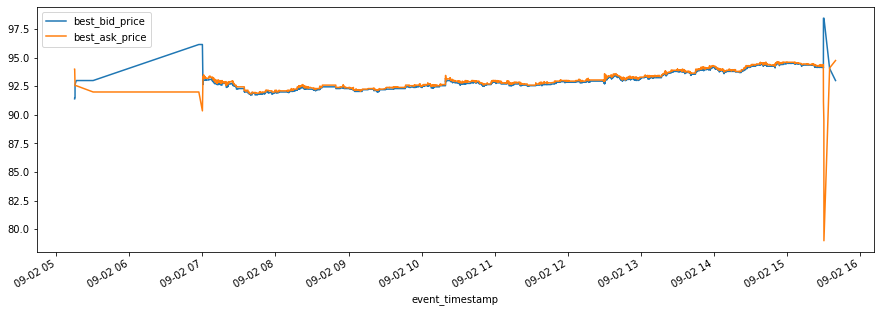

In [50]:
# isolate a stock id from both marketdata to understand the colour of demand/supply over all market states including closed markets

marketdata_stock.plot(kind='line', x='event_timestamp', y=['best_bid_price','best_ask_price'], figsize=(15, 5))

In [ ]:
# Create a Plotly figure
fig = go.Figure()

# Scatter plot
fig.add_trace(go.Scatter(x=merged_all.TradeTime, y=merged_all.Price, mode='markers', marker=dict(color=color_map), name='Price'))

# Line plots
fig.add_trace(go.Scatter(x=merged_all.TradeTime, y=merged_all.best_bid, mode='lines', line=dict(color='blue'), name='best_bid'))
fig.add_trace(go.Scatter(x=merged_all.TradeTime, y=merged_all.best_ask, mode='lines', line=dict(color='orange'), name='best_ask'))

# Update layout
fig.update_layout(
    title='Scatter and Line Plot',
    xaxis_title='X-axis',
    yaxis_title='Y-axis',
    legend=dict(x=0, y=1),
    hovermode='x'  # Hover mode set to 'x' to display hover information for the nearest point on the x-axis
)

# Show plot
fig.show()

In [66]:
import plotly.graph_objects as go
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

# Assume merged_all is a DataFrame containing the data

# Create a Dash app
app = dash.Dash(__name__)

# Create a Plotly figure
fig = go.Figure()

# Scatter plot
fig.add_trace(go.Scatter(x=merged_all.TradeTime, y=merged_all.Price, mode='markers', marker=dict(color=color_map), name='Price'))

# Line plots
fig.add_trace(go.Scatter(x=merged_all.TradeTime, y=merged_all.best_bid, mode='lines', line=dict(color='blue'), name='best_bid'))
fig.add_trace(go.Scatter(x=merged_all.TradeTime, y=merged_all.best_ask, mode='lines', line=dict(color='orange'), name='best_ask'))

# Define the options for the dropdown
dropdown_options = [{'label': stock, 'value': stock} for stock in merged_all.primary_ticker.unique()]

# Create a Dash layout
app.layout = html.Div([
    dcc.Dropdown(
        id='stock-dropdown',
        options=dropdown_options,
        value=merged_all.primary_ticker.unique()[0],  # Set default value to the first stock in the list
        clearable=False  # Prevents the user from clearing the dropdown
    ),
    dcc.Graph(
        id='stock-graph',
        figure=fig
    )
])

# Define callback to update the graph based on dropdown selection
@app.callback(
    Output('stock-graph', 'figure'),
    [Input('stock-dropdown', 'value')]
)
def update_graph(selected_stock):
    filtered_df = merged_all[merged_all.primary_ticker == selected_stock]
    updated_fig = go.Figure()
    updated_fig.add_trace(go.Scatter(x=filtered_df.TradeTime, y=filtered_df.Price, mode='markers', marker=dict(color=color_map), name='Price'))
    updated_fig.add_trace(go.Scatter(x=filtered_df.TradeTime, y=filtered_df.best_bid, mode='lines', line=dict(color='blue'), name='best_bid'))
    updated_fig.add_trace(go.Scatter(x=filtered_df.TradeTime, y=filtered_df.best_ask, mode='lines', line=dict(color='orange'), name='best_ask'))
    updated_fig.update_layout(
        title='Scatter and Line Plot for {}'.format(selected_stock),
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        legend=dict(x=0, y=1),
        hovermode='x'
    )
    return updated_fig

# Run the Dash app
if __name__ == '__main__':
    app.run_server(debug=True)
